In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook

from argparse import Namespace
import os
import collections
from collections import Counter

import string

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Save parameters

In [2]:
def save_torch_to_csv(torch_data,filename):
    pd.DataFrame(torch_data.detach().numpy()).to_csv(filename)

### Set random seeds

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    print(f"seed: {seed}")
    
seed_everything(42)

seed: 42


# 1. SurnameGenerationModel

In [4]:
class SurnameGenerationModel(nn.Module):
    
    def __init__(self, 
                 embedding_dim, 
                 num_embeddings,
                 rnn_hidden_size, 
                 batch_first = True, 
                 padding_idx = 0,
                 dropout_p   = 0.5
                ):
        """
        Args:
            For embedding
            embedding_dim (int)  : The size of the character embeddings
            num_embeddings (int) : The number of characters to embed
                                   len(surname_vocab)
            padding_idx (int)    : The index for the tensor padding
            
            For RNN
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool)   : Informs whether the input tensors will 
                                   have batch or the sequence on the 0th dimension
            For dropout
            dropout_p (float)    : The probability of zeroing activations using 
                                   the dropout method. Higher means more likely to zero.
            
        """
        super(SurnameGenerationModel, self).__init__()

        self.emb = nn.Embedding(num_embeddings = num_embeddings,
                                embedding_dim  = embedding_dim,
                                padding_idx    = padding_idx)
        self.rnn = nn.GRU(input_size   = embedding_dim,
                          hidden_size  = rnn_hidden_size,
                          batch_first  = batch_first)
        self.fc  = nn.Linear(in_features  = rnn_hidden_size,
                             out_features = num_embeddings)
        
    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the model
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_embeddings)
        """
        x_embedded = self.emb(x_in)
        y_out = self.rnn(x_embedded)

        batch_size, seq_size, feat_size = y_out.shape
        y_out = y_out.contiguous().view(batch_size * seq_size, feat_size)

        y_out = self.fc(F.dropout(y_out, p=self._dropout_p))
                         
        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)
            
        new_feat_size = y_out.shape[-1]
        y_out = y_out.view(batch_size, seq_size, new_feat_size)
            
        return y_out

# 2. The Embedding layer

### The x input

In [5]:
seed_everything(42)
batch_size     = 2
length_of_text = 7
my_input = torch.randint(0,20,[batch_size, length_of_text])
my_input

seed: 42


tensor([[ 2,  7, 16, 14,  6, 15,  0],
        [ 4, 10, 13, 18, 14, 10, 14]])

### The nn.Embedding layer
#### More details [Embedding](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Frankenstein/Embedding_layer.ipynb), [Embedding+CNN](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/AGNews/NewsClassifier.ipynb)

In [6]:
# the number of embeddings (the number of vocabulary items)
n_tokens_in_vocabulary = 20
# size of the embeddings (embedding dimension)
dimension_embedding    = 4
# If one specifies padding_idx=0 every input where the value is equal to padding_idx will 
# be zero-ed out 
padding_idx            = 0

In [7]:
seed_everything(42)
my_emb = nn.Embedding(num_embeddings = n_tokens_in_vocabulary, 
                      embedding_dim  = dimension_embedding,
                      padding_idx    = padding_idx)  

seed: 42


In [8]:
### The output of the nn.Embedding layer (i.e.,the input of the RNNCell layer)
x_in = my_emb(my_input)

In [9]:
print("For the nn.Embedding Layer")
print("Shape of input: ", my_input.shape)
print("Shape of output: ", x_in.shape)
print(x_in.shape)
print("-"*60)
print("x_in, the input to the next step")
print(x_in)

For the nn.Embedding Layer
Shape of input:  torch.Size([2, 7])
Shape of output:  torch.Size([2, 7, 4])
torch.Size([2, 7, 4])
------------------------------------------------------------
x_in, the input to the next step
tensor([[[-0.7521,  1.6487, -0.3925, -1.4036],
         [-0.2316,  0.0418, -0.2516,  0.8599],
         [ 1.4451,  0.8564,  2.2181,  0.5232],
         [-1.4032,  0.0360, -0.0635,  0.6756],
         [ 1.2791,  1.2964,  0.6105,  1.3347],
         [-0.0978,  1.8446, -1.1845,  1.3835],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 1.6423, -0.1596, -0.4974,  0.4396],
         [-1.5576,  0.9956, -0.8798, -0.6011],
         [-0.4880,  1.1914, -0.8140, -0.7360],
         [-0.1722,  0.5238,  0.0566,  0.4263],
         [-1.4032,  0.0360, -0.0635,  0.6756],
         [-1.5576,  0.9956, -0.8798, -0.6011],
         [-1.4032,  0.0360, -0.0635,  0.6756]]], grad_fn=<EmbeddingBackward0>)


# 3.  The GRU layer
## [torch.nn.GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)
### AS shown above, the output of the emdedding layer is a tensor with dimension = [2,7,4]. 
### In this context, the three dimensions could be 
- batch_first = True: [batch_size, sequence_size, feature_size]
- batch_first = False: [sequence_size, batch_size, feature_size]

###  The meaning of the three sizes are below:
#### - sequence_size: The length of the sequence, representing the number of time steps in the input sequence. In NLP, this typically corresponds to the number of words (or other basic units) in the input sentence or document. Each time step usually represents one word (or word vector). In this case, sequence_size = 7, meaning that there are seven words in each sentence input, or there are seven characters in each word input. 
#### - batch_size: The size of the batch, indicating the number of samples processed simultaneously during a single training or inference process. A larger batch size can utilize parallel computation to improve efficiency. In NLP, batch size often corresponds to processing multiple sentences or documents in a single input. In this case, batch_size = 2, meaning that there are 2 sentence inputs, or 2 word inputs. 
#### feature_size: The input dimension, representing the number of input features at each time step. In NLP, this typically corresponds to the dimensionality of word embeddings. For example, if each word is represented using 300-dimensional word vectors, then the input_size would be 300. In this case, feature_size = 4, meaning that the embedding dimension is 4, and each word in a sentence of each character in a word is represented by a vector of legnth 4. 

In [10]:
print("Shape of x_in(output of the embedding layer):", x_in.size())
batch_size, seq_size, feat_size = x_in.size()
print("batch_size:", batch_size)
print("seq_size:", seq_size)
print("feat_size:", feat_size)

Shape of x_in(output of the embedding layer): torch.Size([2, 7, 4])
batch_size: 2
seq_size: 7
feat_size: 4


In [11]:
print("Note that batch_first=False, i.e, the first dimension is the batch_size=2")
print("Shape:", x_in.shape)
x_in

Note that batch_first=False, i.e, the first dimension is the batch_size=2
Shape: torch.Size([2, 7, 4])


tensor([[[-0.7521,  1.6487, -0.3925, -1.4036],
         [-0.2316,  0.0418, -0.2516,  0.8599],
         [ 1.4451,  0.8564,  2.2181,  0.5232],
         [-1.4032,  0.0360, -0.0635,  0.6756],
         [ 1.2791,  1.2964,  0.6105,  1.3347],
         [-0.0978,  1.8446, -1.1845,  1.3835],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 1.6423, -0.1596, -0.4974,  0.4396],
         [-1.5576,  0.9956, -0.8798, -0.6011],
         [-0.4880,  1.1914, -0.8140, -0.7360],
         [-0.1722,  0.5238,  0.0566,  0.4263],
         [-1.4032,  0.0360, -0.0635,  0.6756],
         [-1.5576,  0.9956, -0.8798, -0.6011],
         [-1.4032,  0.0360, -0.0635,  0.6756]]], grad_fn=<EmbeddingBackward0>)

In [12]:
rnn_hidden_size = 3
seed_everything(42)
my_GRU = nn.GRU(input_size   = dimension_embedding,
                hidden_size  = rnn_hidden_size,
                batch_first  = True)

seed: 42


In [13]:
list(my_GRU.named_parameters())

[('weight_ih_l0',
  Parameter containing:
  tensor([[ 0.4414,  0.4792, -0.1353,  0.5304],
          [-0.1265,  0.1165, -0.2811,  0.3391],
          [ 0.5090, -0.4236,  0.5018,  0.1081],
          [ 0.4266,  0.0782,  0.2784, -0.0815],
          [ 0.4451,  0.0853, -0.2695,  0.1472],
          [-0.2660, -0.0677, -0.2345,  0.3830],
          [-0.4557, -0.2662, -0.1630, -0.3471],
          [ 0.0545, -0.5702,  0.5214, -0.4904],
          [ 0.4457,  0.0961, -0.1875,  0.3568]], requires_grad=True)),
 ('weight_hh_l0',
  Parameter containing:
  tensor([[ 0.0900,  0.4665,  0.0631],
          [-0.1821,  0.1551, -0.1566],
          [ 0.2430,  0.5155,  0.3337],
          [-0.2524,  0.3333,  0.1033],
          [ 0.2932, -0.3519, -0.5715],
          [-0.2231, -0.4428,  0.4737],
          [ 0.1663,  0.2391,  0.1826],
          [-0.0100,  0.4518, -0.4102],
          [ 0.0364, -0.3941,  0.1780]], requires_grad=True)),
 ('bias_ih_l0',
  Parameter containing:
  tensor([-0.1988,  0.1769, -0.1203,  0.4788, -

In [14]:
W_i  = list(my_GRU.named_parameters())[0]
W_ir = W_i[1][0:3,]
W_iz = W_i[1][3:6,]
W_in = W_i[1][6:9,]

W_h  = list(my_GRU.named_parameters())[1]
W_hr = W_h[1][0:3,]
W_hz = W_h[1][3:6,]
W_hn = W_h[1][6:9,]


b_i  = list(my_GRU.named_parameters())[2]
b_ir = b_i[1][0:3,]
b_iz = b_i[1][3:6,]
b_in = b_i[1][6:9,]

b_h  = list(my_GRU.named_parameters())[3]
b_hr = b_h[1][0:3,]
b_hz = b_h[1][3:6,]
b_hn = b_h[1][6:9,]

In [15]:
initial_hidden = torch.zeros((1, batch_size, rnn_hidden_size))
initial_hidden

tensor([[[0., 0., 0.],
         [0., 0., 0.]]])

In [16]:
### The argument "h_0 = initial_hidden" can be omitted 
### because h_0 defaults to zeros if not provided.
output, h_final = my_GRU(x_in, initial_hidden)
output

tensor([[[ 0.1172,  0.1572, -0.2561],
         [-0.1366,  0.2296,  0.0123],
         [-0.2915,  0.6269,  0.2816],
         [ 0.0353,  0.4332,  0.0559],
         [-0.2430,  0.1105,  0.4706],
         [-0.4794, -0.5260,  0.5597],
         [-0.3822,  0.2125,  0.4188]],

        [[-0.2737,  0.1863,  0.4307],
         [ 0.2448, -0.0473,  0.0761],
         [ 0.1612, -0.0539,  0.0057],
         [-0.1260,  0.1383,  0.1138],
         [ 0.0743,  0.2793, -0.0166],
         [ 0.3817,  0.0793, -0.2301],
         [ 0.2545,  0.2858, -0.2370]]], grad_fn=<TransposeBackward1>)

In [17]:
manual_output = []

h = initial_hidden
for t in range(seq_size):
    x_t = x_in[:,t,:]
    print("Time Step ", t)
    print("r(reset)")
    r = torch.sigmoid(torch.matmul(x_t, W_ir.T)+b_ir+torch.matmul(h, W_hr.T)+b_hr).squeeze(0)
    print(r)
    print("z(update)")
    z = torch.sigmoid(torch.matmul(x_t, W_iz.T)+b_iz + torch.matmul(h, W_hz.T)+b_hz).squeeze(0)
    print(z)
    print("n(new gates)")
    n = (torch.matmul(h, W_hn.T)+b_hn)*r+torch.matmul(x_t, W_in.T)+b_in
    n = torch.tanh(n).squeeze(0)
    print(n)
    print("h(hidden state)")
    h = (1-z)*n+z*h
    h = h.squeeze(0)
    print(h)
    manual_output.append(h)
    print("-"*100)

manual_h_final = h

Time Step  0
r(reset)
tensor([[0.5308, 0.4066, 0.1069],
        [0.7868, 0.4410, 0.5021]], grad_fn=<SqueezeBackward1>)
z(update)
tensor([[0.4602, 0.2640, 0.3852],
        [0.6320, 0.5462, 0.4374]], grad_fn=<SqueezeBackward1>)
n(new gates)
tensor([[ 0.2171,  0.2136, -0.4165],
        [-0.7439,  0.4107,  0.7655]], grad_fn=<SqueezeBackward1>)
h(hidden state)
tensor([[ 0.1172,  0.1572, -0.2561],
        [-0.2737,  0.1863,  0.4307]], grad_fn=<SqueezeBackward1>)
----------------------------------------------------------------------------------------------------
Time Step  1
r(reset)
tensor([[0.6968, 0.5349, 0.3020],
        [0.5090, 0.5171, 0.0962]], grad_fn=<SqueezeBackward1>)
z(update)
tensor([[0.4472, 0.3751, 0.5298],
        [0.3590, 0.1705, 0.5975]], grad_fn=<SqueezeBackward1>)
n(new gates)
tensor([[-0.3418,  0.2731,  0.3148],
        [ 0.5352, -0.0953, -0.4503]], grad_fn=<SqueezeBackward1>)
h(hidden state)
tensor([[-0.1366,  0.2296,  0.0123],
        [ 0.2448, -0.0473,  0.0761]], grad_

In [18]:
manual_output = torch.stack(manual_output).permute(1,0,2)
manual_output

tensor([[[ 0.1172,  0.1572, -0.2561],
         [-0.1366,  0.2296,  0.0123],
         [-0.2915,  0.6269,  0.2816],
         [ 0.0353,  0.4332,  0.0559],
         [-0.2430,  0.1105,  0.4706],
         [-0.4794, -0.5260,  0.5597],
         [-0.3822,  0.2125,  0.4188]],

        [[-0.2737,  0.1863,  0.4307],
         [ 0.2448, -0.0473,  0.0761],
         [ 0.1612, -0.0539,  0.0057],
         [-0.1260,  0.1383,  0.1138],
         [ 0.0743,  0.2793, -0.0166],
         [ 0.3817,  0.0793, -0.2301],
         [ 0.2545,  0.2858, -0.2370]]], grad_fn=<PermuteBackward0>)

In [19]:
output

tensor([[[ 0.1172,  0.1572, -0.2561],
         [-0.1366,  0.2296,  0.0123],
         [-0.2915,  0.6269,  0.2816],
         [ 0.0353,  0.4332,  0.0559],
         [-0.2430,  0.1105,  0.4706],
         [-0.4794, -0.5260,  0.5597],
         [-0.3822,  0.2125,  0.4188]],

        [[-0.2737,  0.1863,  0.4307],
         [ 0.2448, -0.0473,  0.0761],
         [ 0.1612, -0.0539,  0.0057],
         [-0.1260,  0.1383,  0.1138],
         [ 0.0743,  0.2793, -0.0166],
         [ 0.3817,  0.0793, -0.2301],
         [ 0.2545,  0.2858, -0.2370]]], grad_fn=<TransposeBackward1>)

In [20]:
manual_h_final

tensor([[-0.3822,  0.2125,  0.4188],
        [ 0.2545,  0.2858, -0.2370]], grad_fn=<SqueezeBackward1>)

In [21]:
h_final

tensor([[[-0.3822,  0.2125,  0.4188],
         [ 0.2545,  0.2858, -0.2370]]], grad_fn=<StackBackward0>)

# 5. The Linear layers

In [22]:
batch_size, seq_size, feat_size = output.shape
y_out = output.contiguous().view(batch_size * seq_size, feat_size)
y_out

tensor([[ 0.1172,  0.1572, -0.2561],
        [-0.1366,  0.2296,  0.0123],
        [-0.2915,  0.6269,  0.2816],
        [ 0.0353,  0.4332,  0.0559],
        [-0.2430,  0.1105,  0.4706],
        [-0.4794, -0.5260,  0.5597],
        [-0.3822,  0.2125,  0.4188],
        [-0.2737,  0.1863,  0.4307],
        [ 0.2448, -0.0473,  0.0761],
        [ 0.1612, -0.0539,  0.0057],
        [-0.1260,  0.1383,  0.1138],
        [ 0.0743,  0.2793, -0.0166],
        [ 0.3817,  0.0793, -0.2301],
        [ 0.2545,  0.2858, -0.2370]], grad_fn=<ViewBackward0>)

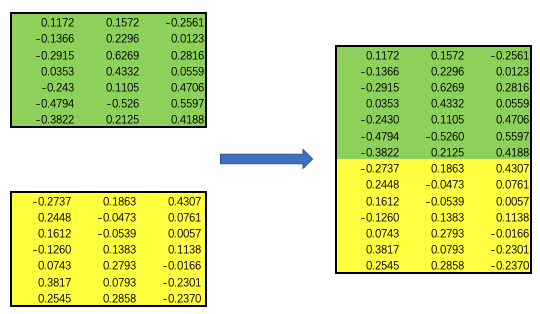

In [23]:
seed_everything(42)
fc = nn.Linear(in_features   = rnn_hidden_size, 
               out_features  = seq_size)

seed: 42


In [24]:
list(fc.named_parameters())

[('weight',
  Parameter containing:
  tensor([[ 0.4414,  0.4792, -0.1353],
          [ 0.5304, -0.1265,  0.1165],
          [-0.2811,  0.3391,  0.5090],
          [-0.4236,  0.5018,  0.1081],
          [ 0.4266,  0.0782,  0.2784],
          [-0.0815,  0.4451,  0.0853],
          [-0.2695,  0.1472, -0.2660]], requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([-0.0677, -0.2345,  0.3830, -0.4557, -0.2662, -0.1630, -0.3471],
         requires_grad=True))]

In [25]:
y_out = fc(output)
y_out

tensor([[[ 0.0940, -0.2221,  0.2730, -0.4541, -0.2752, -0.1245, -0.2875],
         [-0.0196, -0.3345,  0.5055, -0.2813, -0.3030, -0.0486, -0.2798],
         [ 0.0659, -0.4356,  0.8208,  0.0127, -0.2631,  0.1638, -0.2512],
         [ 0.1479, -0.2641,  0.5484, -0.2473, -0.2017,  0.0317, -0.3078],
         [-0.1857, -0.3225,  0.7283, -0.2465, -0.2301, -0.0539, -0.3906],
         [-0.6070, -0.3570,  0.6243, -0.4562, -0.3559, -0.3103, -0.4442],
         [-0.1912, -0.4153,  0.7756, -0.1420, -0.2960, -0.0016, -0.3242]],

        [[-0.1575, -0.3531,  0.7423, -0.1997, -0.2485, -0.0210, -0.3605],
         [ 0.0074, -0.0898,  0.3369, -0.5749, -0.1443, -0.1975, -0.4403],
         [-0.0232, -0.1415,  0.3224, -0.5504, -0.2000, -0.1996, -0.4000],
         [-0.0724, -0.3056,  0.5232, -0.3207, -0.2774, -0.0815, -0.3231],
         [ 0.1012, -0.2323,  0.4483, -0.3489, -0.2172, -0.0462, -0.3217],
         [ 0.1699, -0.0689,  0.1855, -0.6025, -0.1612, -0.1785, -0.3771],
         [ 0.2137, -0.1633,  0.2878,

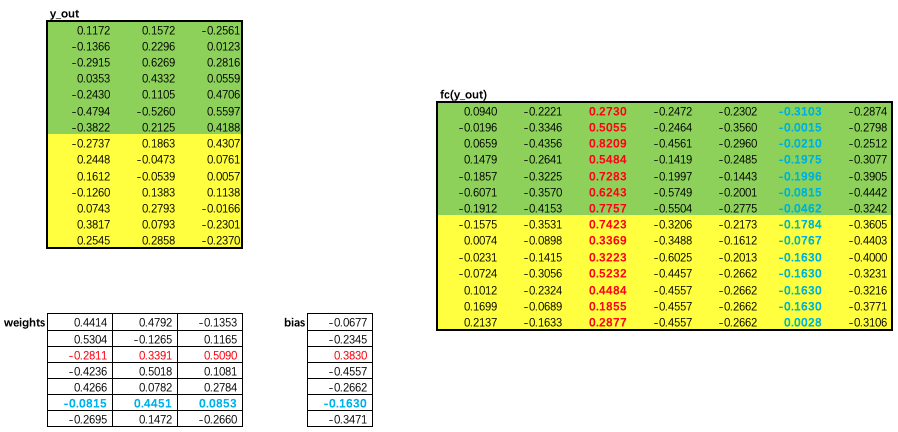

In [26]:
new_feat_size = y_out.shape[-1]
y_out = y_out.view(batch_size, seq_size, new_feat_size)
y_out

tensor([[[ 0.0940, -0.2221,  0.2730, -0.4541, -0.2752, -0.1245, -0.2875],
         [-0.0196, -0.3345,  0.5055, -0.2813, -0.3030, -0.0486, -0.2798],
         [ 0.0659, -0.4356,  0.8208,  0.0127, -0.2631,  0.1638, -0.2512],
         [ 0.1479, -0.2641,  0.5484, -0.2473, -0.2017,  0.0317, -0.3078],
         [-0.1857, -0.3225,  0.7283, -0.2465, -0.2301, -0.0539, -0.3906],
         [-0.6070, -0.3570,  0.6243, -0.4562, -0.3559, -0.3103, -0.4442],
         [-0.1912, -0.4153,  0.7756, -0.1420, -0.2960, -0.0016, -0.3242]],

        [[-0.1575, -0.3531,  0.7423, -0.1997, -0.2485, -0.0210, -0.3605],
         [ 0.0074, -0.0898,  0.3369, -0.5749, -0.1443, -0.1975, -0.4403],
         [-0.0232, -0.1415,  0.3224, -0.5504, -0.2000, -0.1996, -0.4000],
         [-0.0724, -0.3056,  0.5232, -0.3207, -0.2774, -0.0815, -0.3231],
         [ 0.1012, -0.2323,  0.4483, -0.3489, -0.2172, -0.0462, -0.3217],
         [ 0.1699, -0.0689,  0.1855, -0.6025, -0.1612, -0.1785, -0.3771],
         [ 0.2137, -0.1633,  0.2878,

In [27]:
y_out.max(dim=1)

torch.return_types.max(
values=tensor([[ 0.1479, -0.2221,  0.8208,  0.0127, -0.2017,  0.1638, -0.2512],
        [ 0.2137, -0.0689,  0.7423, -0.1997, -0.1443, -0.0210, -0.3106]],
       grad_fn=<MaxBackward0>),
indices=tensor([[3, 0, 2, 2, 3, 2, 2],
        [6, 5, 0, 0, 1, 0, 6]]))

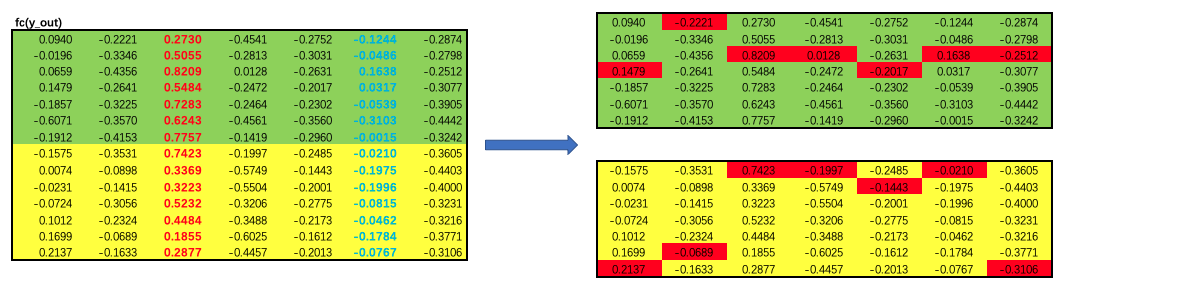